# Lab 12: Cluster Visualization

**Learning Objectives:**
1. Apply PCA, t-SNE, and UMAP for cluster validation
2. Tune key parameters (perplexity, n_neighbors, min_dist) and understand their effects
3. Compare visualization methods for different stakeholder needs
4. Translate visual patterns into marketing strategy implications
5. Select appropriate visualization methods based on audience and objectives


In [1]:
# !pip install umap-learn

In [2]:

# Standard library
import warnings
from collections import Counter

# Data manipulation
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

# Clustering
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN

# Dimensionality Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

# Configuration
warnings.filterwarnings('ignore')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

In [3]:
# Load preprocessed data from Lab 13
df = pd.read_csv('../data/data_preprocessed.csv')

df

age    income       frq       rcn   mnt   clothes   kitchen  \
0      78  0.743162  1.191605  0.457819  1402 -0.617023 -0.243065   
1      88  1.559488  1.100011 -1.535723  1537  0.166160 -0.790228   
2      34 -1.548542 -0.823463  0.557496    44 -0.834573  1.672006   
3      69  0.845528  0.550447 -1.402820   888  0.383710  0.440889   
4      69  0.782435  1.008417 -0.871209  1138  0.340200 -0.243065   
...   ...       ...       ...       ...   ...       ...       ...   
8812   70  0.618993  0.458853 -1.701851   837  0.209670  0.167308   
8813   64  0.874744  0.733635 -1.701851   896  0.731791 -0.243065   
8814   49 -0.455617 -0.731869 -1.535723    61  0.079139 -0.106274   
8815   38 -0.596155  0.825229  0.657173  1011 -0.442982  0.577680   
8816   86  2.034397  1.649574  0.756850  1668  0.427220 -0.653437   

      small_appliances      toys  house_keeping  ...  oh_status_Married  \
0             1.216847  0.495837      -0.499274  ...                0.0   
1             0.740464 -0.374374      -0.631907  ...                0.0   
2            -0.371096 -0.809480       2.286023  ...                1.0   
3            -0.768082 -0.084304      -0.234007  ...                1.0   
4            -0.053508 -0.374374      -0.366640  ...                0.0   
...                ...       ...            ...  ...                ...   
8812         -0.132905  0.205767      -0.764540  ...                1.0   
8813         -0.609288 -0.519409      -0.366640  ...                0.0   
8814         -0.053508  0.060732      -0.101374  ...                0.0   
8815          0.581670 -0.809480       0.561792  ...                0.0   
8816         -0.291699 -0.229339      -0.101374  ...                1.0   

      oh_status_Single oh_status_Together oh_status_Widow oh_gender_M  \
0                  0.0                1.0             0.0         1.0   
1                  0.0                0.0             0.0         0.0   
2                  0.0                0.0             0.0         1.0   
3                  0.0                0.0             0.0         0.0   
4                  0.0                1.0             0.0         0.0   
...                ...                ...             ...         ...   
8812               0.0                0.0             0.0         1.0   
8813               1.0                0.0             0.0         0.0   
8814               1.0                0.0             0.0         1.0   
8815               0.0                1.0             0.0         1.0   
8816               0.0                0.0             0.0         1.0   

     oh_dependents_1.0  oh_description_Kind of OK  oh_description_Meh...  \
0                  0.0                        0.0                    0.0   
1                  0.0                        0.0                    0.0   
2                  1.0                        1.0                    0.0   
3                  1.0                        0.0                    0.0   
4                  1.0                        0.0                    0.0   
...                ...                        ...                    ...   
8812               1.0                        1.0                    0.0   
8813               1.0                        0.0                    0.0   
8814               1.0                        0.0                    1.0   
8815               0.0                        0.0                    0.0   
8816               1.0                        0.0                    0.0   

      oh_description_OK nice!  oh_description_Take my money!!  
0                         0.0                             1.0  
1                         0.0                             1.0  
2                         0.0                             0.0  
3                         1.0                             0.0  
4                         0.0                             1.0  
...                       ...                             ...  
8812                      0.0         

In [4]:
# Define feature perspectives (from Lab 13)

# Behavioral features (how customers shop)
behavioral_features = [
    'income',
    'frq',
    'per_net_purchase',
    'spent_online'
]

# Product Preference features (what customers buy)
preference_features = [
    'clothes',
    'kitchen',
    'small_appliances',
    'toys',
    'house_keeping'
]

# Combined metric features (all 9 features)
metric_features = behavioral_features + preference_features

print("Feature perspectives defined:")
print(f"Behavioral: {len(behavioral_features)} features")
print(f"Product Preference: {len(preference_features)} features")
print(f"Total: {len(metric_features)} features")

Feature perspectives defined:
Behavioral: 4 features
Product Preference: 5 features
Total: 9 features


### Outlier removal 

In [5]:
# Remove outliers using DBSCAN 
dbscan = DBSCAN(eps=1.9, min_samples=20, n_jobs=4)
dbscan_labels = dbscan.fit_predict(df[metric_features])

outlier_count = Counter(dbscan_labels)
print(f"Outliers detected: {outlier_count[-1]}")

# Filter to core customers only
df = df[dbscan_labels != -1].copy()

Outliers detected: 25


### Perspective Clusteering 

In [6]:

# Behavioral clustering (K=4)
kmeans_behav = KMeans(n_clusters=4, init='k-means++', n_init=20, random_state=42)
df['behavior_labels'] = kmeans_behav.fit_predict(df[behavioral_features])


# Product Preference clustering (K=3)
kmeans_pref = KMeans(n_clusters=3, init='k-means++', n_init=20, random_state=42)
df['product_labels'] = kmeans_pref.fit_predict(df[preference_features])


### Merging perspectives (K = 7)

In [7]:
# Calculate centroids for 4*3 = 12 combinations
df_centroids = df.groupby(['behavior_labels', 'product_labels'])[metric_features].mean()

hclust_final = AgglomerativeClustering(linkage='ward', n_clusters=7)
hclust_final_labels = hclust_final.fit_predict(df_centroids)

# Create mapper and assign merged labels
df_centroids['merged_labels'] = hclust_final_labels


In [8]:
# Apply the centroids labels to the original dataframe
cluster_mapper = df_centroids['merged_labels'].to_dict()

df['labels'] = df.apply(
    lambda row: cluster_mapper[(row['behavior_labels'], row['product_labels'])],
    axis=1
)

In [9]:
df['labels'].value_counts().sort_index()

labels
0     302
1    1641
2    2131
3    1022
4     495
5    2492
6     709
Name: count, dtype: int64

#### We want to visualize the clusters in the feature space, what's the problem ? 

In [10]:
len(metric_features)

9

.

.

.

.

# Dimensionality Reduction for Cluster Visualization

.

.

# PCA 

Principal Component Analysis 

![](../figures/cluster_visualisation/pca.png)

Characteristics:
- Linear transformation, ortogonal components
- Each component explains a % of variance
- Global relationships between points
- Interpretable components (PC1 and PC2)
- Deterministic (same result every time)


In [11]:
#  Apply PCA
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(df[metric_features])

X_pca

array([[ 0.91798365, -1.9720514 ],
       [ 1.92011426, -1.38596373],
       [-2.79413989,  0.36529153],
       ...,
       [-1.07502958,  1.34682833],
       [ 0.1571694 , -0.99055933],
       [ 3.26521031, -1.41196616]])

In [12]:
X_pca.shape

(8792, 2)

In [13]:

# Add to dataframe
df['pca_1'] = X_pca[:, 0]
df['pca_2'] = X_pca[:, 1]

# Variance explained
var_explained = pca.explained_variance_ratio_
print(f"PCA Variance Explained:")
print(f"  PC1:      {var_explained[0]:.1%}")
print(f"  PC2:      {var_explained[1]:.1%}")
print("="*20)
print(f"  Total:    {var_explained.sum():.1%}")

PCA Variance Explained:
  PC1:      39.3%
  PC2:      26.8%
  Total:    66.0%


#### How much information is lost in 2D PCA projection?

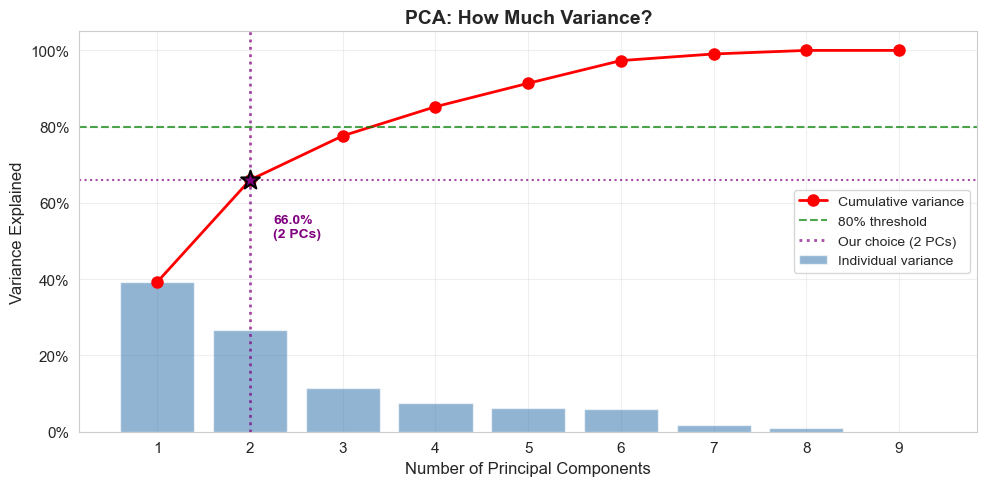


Variance Explained by Each Component:
  PC1:  39.3% | Cumulative:  39.3%
  PC2:  26.8% | Cumulative:  66.0%
  PC3:  11.6% | Cumulative:  77.6%
  PC4:   7.6% | Cumulative:  85.2%
  PC5:   6.1% | Cumulative:  91.4%
  PC6:   6.0% | Cumulative:  97.3%
  PC7:   1.7% | Cumulative:  99.1%
  PC8:   0.9% | Cumulative: 100.0%
  PC9:   0.0% | Cumulative: 100.0%

2 components capture 66.0% of variance
Trade-off: Simplicity (2D visualization) vs. Information loss (34.0%)


In [14]:
# Visualize cumulative variance explained
# First, fit PCA with all 9 components to see full variance distribution
pca_full = PCA(n_components=len(metric_features), random_state=42)
pca_full.fit(df[metric_features])

# Calculate cumulative variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Create plot
fig, ax = plt.subplots(figsize=(10, 5))

# Plot individual variance (bar chart)
ax.bar(range(1, len(metric_features) + 1), 
       pca_full.explained_variance_ratio_,
       alpha=0.6, color='steelblue', label='Individual variance')

# Plot cumulative variance (line)
ax.plot(range(1, len(metric_features) + 1), 
        cumulative_variance, 
        marker='o', color='red', linewidth=2, markersize=8,
        label='Cumulative variance')

# Add horizontal line for common thresholds
ax.axhline(y=0.80, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='80% threshold')

# Highlight our choice (2 components)
ax.axhline(y=cumulative_variance[1], color='purple', linestyle=':', linewidth=1.5, alpha=0.7, )
ax.axvline(x=2, color='purple', linestyle=':', linewidth=2, alpha=0.7, label='Our choice (2 PCs)')
ax.scatter(2, cumulative_variance[1], s=200, c='purple', marker='*', zorder=10, 
           edgecolors='black', linewidths=1.5)

# Add text annotation for our choice
ax.text(2.25, cumulative_variance[1] - 0.15, 
        f'{cumulative_variance[1]:.1%}\n(2 PCs)', 
        ha='left', fontsize=10, weight='bold', color='purple')

# Formatting
ax.set_xlabel('Number of Principal Components', fontsize=12)
ax.set_ylabel('Variance Explained', fontsize=12)
ax.set_title('PCA: How Much Variance?', fontsize=14, weight='bold')
ax.set_xticks(range(1, len(metric_features) + 1))
ax.set_ylim(0, 1.05)
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0%}'))
ax.grid(True, alpha=0.3)
ax.legend(loc='center right', fontsize=10)

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print("Variance Explained by Each Component:")
print(f"{'='*60}")
for i, (var, cum_var) in enumerate(zip(pca_full.explained_variance_ratio_, cumulative_variance)):
    print(f"  PC{i+1}: {var:6.1%} | Cumulative: {cum_var:6.1%}")
print(f"{'='*60}")
print(f"\n2 components capture {cumulative_variance[1]:.1%} of variance")
print(f"Trade-off: Simplicity (2D visualization) vs. Information loss ({1-cumulative_variance[1]:.1%})")

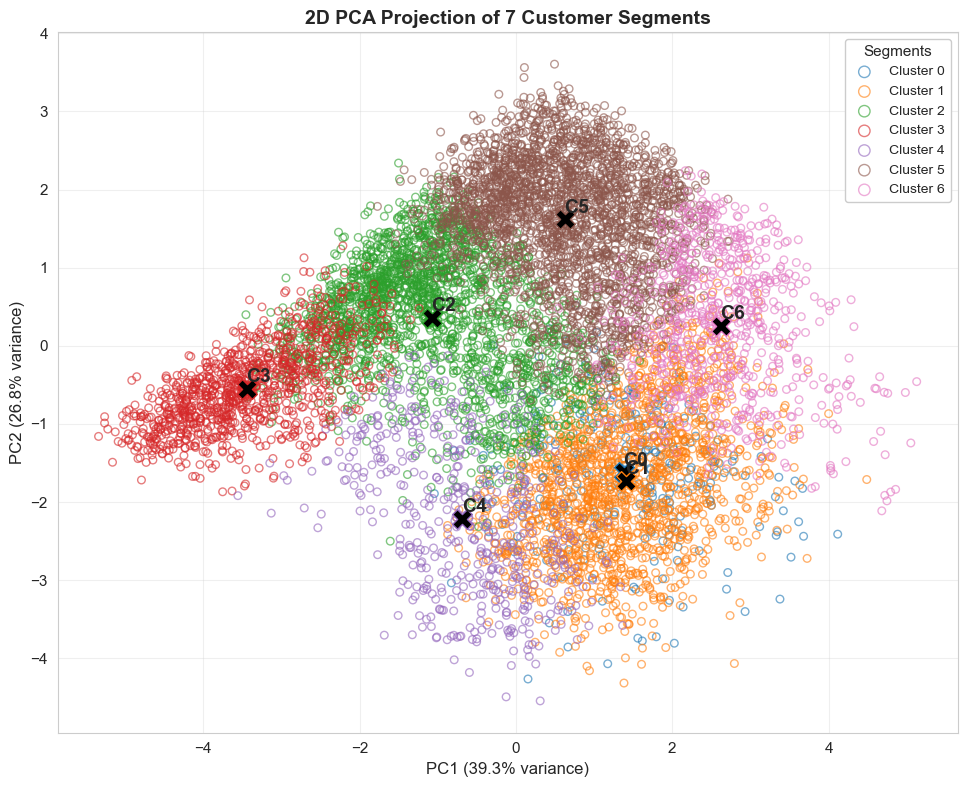

In [15]:
# Visualize PCA projection
fig, ax = plt.subplots(figsize=(12, 8))


colors = cm.tab10(np.linspace(0, 1, 10))

# Plot each cluster separately to create legend entries
for label in sorted(df['labels'].unique()):
    cluster_data = df[df['labels'] == label]
    ax.scatter(
        cluster_data['pca_1'],
        cluster_data['pca_2'],
        ######################
        c='none',
        edgecolors=[colors[label]],
        ######################
        alpha=0.6,
        s=30,
        label=f'Cluster {label}'
    )

# Add cluster centroids
for label in sorted(df['labels'].unique()):
    cluster_data = df[df['labels'] == label]
    centroid_x = cluster_data['pca_1'].mean()
    centroid_y = cluster_data['pca_2'].mean()
    ax.scatter(centroid_x, centroid_y, c='black', marker='X', s=200, 
               edgecolors=colors[label], linewidths=1, zorder=10)
    ax.annotate(f'C{label}', (centroid_x+.15, centroid_y+.15), 
                fontsize=14, weight='bold', ha='center', va='center', zorder=20)

# Add legend instead of colorbar
ax.legend(loc='best', framealpha=1, title='Segments', fontsize=10, markerscale=1.5)

ax.set_xlabel(f'PC1 ({var_explained[0]:.1%} variance)', fontsize=12)
ax.set_ylabel(f'PC2 ({var_explained[1]:.1%} variance)', fontsize=12)
ax.set_title('2D PCA Projection of 7 Customer Segments', fontsize=14, weight='bold')
ax.grid(True, alpha=0.3)
ax.set_aspect(1)
plt.tight_layout()

plt.show()

#### What are the segments better separated by each PCA component?
#### Which segments overlap significantly?      
#### Does the overlap mean necessarily poor segmentation? 

PCA Loadings vs. Correlations

PCA Loadings

- Definition: The coefficients in the linear combination that defines each PC
- Formula: PC1 = loading1×feature1 + loading2×feature2 + ... + loading9×feature9
- Properties:
- Not bounded (can be any value)
- Unit vectors (when normalized)
- Show the weight each feature contributes to the PC
- Directly from pca.components_

Correlations 

- Definition: Pearson correlation between the original features and the PC scores
- Formula: correlation(feature_i, PC_j)
- Properties:
- Bounded between -1 and +1
- Easier to interpret (correlation scale familiar to stakeholders)
- Show the strength of relationship between feature and PC
- Need to calculate: corr = loadings × sqrt(eigenvalues)

Key Difference

- Loadings tell you how to construct the PC from features.
- Correlations tell you how strongly related each feature is to the resulting PC.

In [16]:

pc_corr = df[metric_features+['pca_1', 'pca_2']].corr().round(3)
pc_corr = pc_corr.loc[metric_features, ['pca_1', 'pca_2']]
pc_corr

pca_1  pca_2
income            0.765 -0.537
frq               0.724 -0.609
per_net_purchase -0.458  0.660
spent_online      0.729 -0.302
clothes           0.726  0.665
kitchen          -0.596 -0.425
small_appliances -0.301 -0.496
toys             -0.588 -0.436
house_keeping    -0.606 -0.397

In [17]:
#  Interpret PCA components (feature loadings)
# What do PC1 and PC2 represent?

loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=metric_features
)

print("PCA Component Loadings (Feature Contributions):\n")
print(loadings.round(3))

PCA Component Loadings (Feature Contributions):

                    PC1    PC2
income            0.408 -0.347
frq               0.386 -0.394
per_net_purchase -0.244  0.426
spent_online      0.387 -0.194
clothes           0.387  0.429
kitchen          -0.317 -0.274
small_appliances -0.161 -0.321
toys             -0.312 -0.280
house_keeping    -0.320 -0.254


In [18]:
fig, axes = plt.subplots(1,2)


sns.heatmap(loadings, annot=True, cmap='PiYG', center=0, ax=axes[0])
axes[0].set_title('PCA Component Loadings', fontsize=14, weight='bold')

sns.heatmap(pc_corr, annot=True, cmap='PiYG', center=0, ax=axes[1])
axes[1].set_title('PCA Component Correlation', fontsize=14, weight='bold')



plt.tight_layout()
plt.show()

If you have a high value of PC1.... then what?

If you have a high value of PC2.... then what?


#### What features diffentiates the first two components?
#### Give names to PC1 and PC2 based on the loadings

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# PCA Projection
ax = axes[0]
for label in sorted(df['labels'].unique()):
    cluster_data = df[df['labels'] == label]
    ax.scatter(
        cluster_data['pca_1'],
        cluster_data['pca_2'],
        c=[colors[label]],
        alpha=0.6,
        s=30,
        edgecolors='none',
        label=f'Cluster {label}'
    )
ax.set_xlabel(f'PC1 (rich-in-store)', fontsize=12)
ax.set_ylabel(f'PC2 (poor-online)', fontsize=12)
ax.legend(loc='best', framealpha=1, title='Segments', fontsize=10, markerscale=1.5)
ax.set_title('2D PCA Projection of 7 Customer Segments', fontsize=14, weight='bold')
ax.grid(True, alpha=0.3)
ax.set_aspect(1)

# Loadings Heatmap
ax = axes[1]
sns.heatmap(loadings, annot=True, cmap='PiYG', center=0, ax=ax)
ax.set_title('PCA Component Loadings', fontsize=14, weight='bold')  
plt.tight_layout()
plt.show()

|               | PC1 Low  <br>(poor-online/others)         | PC1 High <br>(rich-in-store/clothes)        |
|---------------|---------------------------------|---------------------------------|
| PC2 High <br>(poor-online/clothes)      | poor++/online++/0    | 0 / 0 / clothes++   |
| PC2 Low <br>(rich-in-store/others)       | 0 / 0 / others++    | rich++/in-store++/0    |

#### Describe Cluster 3 in terms of the Principal Components

PC1: High or low?
- low

PC2: High or low?
- average

In [20]:

pc_cluster = df[metric_features+['labels', 'pca_1', 'pca_2']].groupby('labels').mean().round(3).T

fig, ax = plt.subplots(figsize=(12,6))

sns.heatmap(pc_cluster, annot=True, cmap='PiYG', center=0, ax=ax)
ax.set_title('PCA Component Cluster Means', fontsize=14, weight='bold')  

plt.tight_layout()
plt.show()

#### What marketing strategies would you suggest for cluster 3 (red)? 

.

.

.

.

# t-SNE 

t-Distributed Stochastic Neighbor Embedding


![](../figures/cluster_visualisation/tsne.png)


Comparison of 2 distributions with Kullback-Leibler divergence (KL divergence) (preserving neigbhor probabilities)

Characteristics:
- Preserves better local structure
- Need to tune perplexity to balance local/global structure
- Stochastic nature: different runs produce variations (++ if random initialization)

[More](https://distill.pub/2016/misread-tsne/) on t-SNE and perplexity tuning

### `perplexity`

Number of nearest neighbors considered
<br>
Default is 30 

t-SNE with different perplexities

![](../figures/cluster_visualisation/tsne_perplexity_1.png)

Global distances may not be preserved

![](../figures/cluster_visualisation/tsne_perplexity_2.png)
Sizes may not be preserved

![](../figures/cluster_visualisation/tsne_perplexity_3.png)

In [21]:
perplexity_values = [2, 30, 50]
tsne_results = {}

for perp in perplexity_values:
    print(f"Computing t-SNE with perplexity={perp}...")
    tsne = TSNE(
        n_components=2,
        perplexity=perp,
        random_state=42,
        max_iter=1000,
        learning_rate='auto',
        init='random'
    )
    X_tsne = tsne.fit_transform(df[metric_features])
    tsne_results[perp] = X_tsne

Computing t-SNE with perplexity=2...
Computing t-SNE with perplexity=30...
Computing t-SNE with perplexity=50...


In [22]:
tsne_results[2].shape

(8792, 2)

In [23]:
# Visualize perplexity comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Get number of unique clusters
n_clusters = df['labels'].nunique()

# Create color map
colors = cm.tab10(np.linspace(0, 1, 10))

for idx, perp in enumerate(perplexity_values):
    ax = axes[idx]
    X_tsne = tsne_results[perp]
    
    # Plot each cluster separately for legend
    for label in sorted(df['labels'].unique()):
        mask = df['labels'] == label
        ax.scatter(
            X_tsne[mask, 0],
            X_tsne[mask, 1],
            c=[colors[label]],
            alpha=0.6,
            s=20,
            edgecolors='none',
            label=f'Cluster {label}' if idx == 0 else ''  # Only label first subplot
        )
    
    ax.set_title(f't-SNE (perplexity={perp})', fontsize=12, weight='bold')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_aspect(1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(right=0.88)  # Make room for legend
plt.show()

#### What value of perplexity gives the worst data separation? 

#### What values of perplexity provide better global structure of the data ?

.



### Stability Testing

In [24]:
#  Stability test - multiple runs with same perplexity
perp_test = 5
random_seeds = [42, 3970266, 109726]
stability_results = {}

print(f"Testing stability with perplexity={perp_test}\n")
for seed in random_seeds:
    print(f"Run with random_state={seed}")
    tsne = TSNE(
        n_components=2,
        perplexity=perp_test,
        random_state=seed,
        max_iter=1000,
        learning_rate='auto',
        init='random'
    )
    X_tsne = tsne.fit_transform(df[metric_features])
    stability_results[seed] = X_tsne

Testing stability with perplexity=5

Run with random_state=42
Run with random_state=3970266
Run with random_state=109726


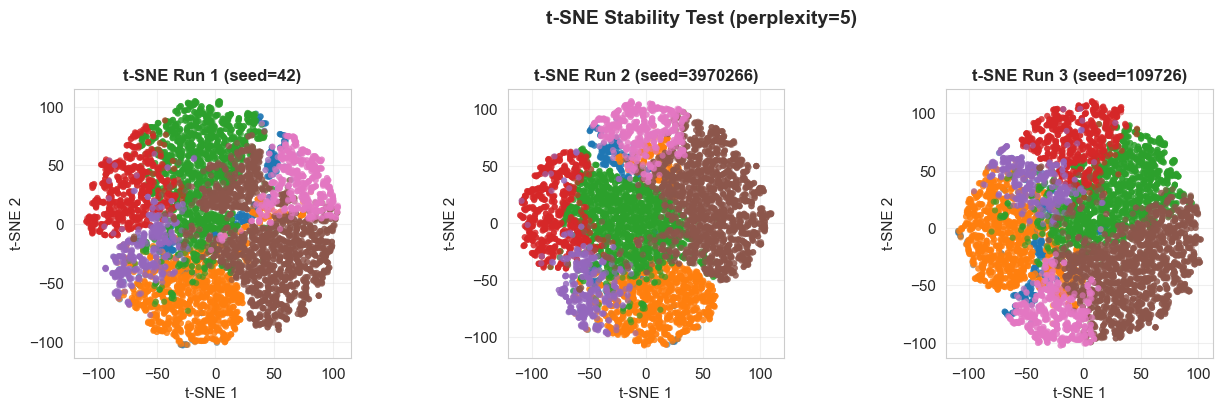

In [25]:
# Visualize stability comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Get number of unique clusters
n_clusters = df['labels'].nunique()

# Create color map
colors = cm.tab10(np.linspace(0, 1, 10))

for idx, seed in enumerate(random_seeds):
    ax = axes[idx]
    X_tsne = stability_results[seed]
    
    # Plot each cluster separately for legend
    for label in sorted(df['labels'].unique()):
        mask = df['labels'] == label
        ax.scatter(
            X_tsne[mask, 0],
            X_tsne[mask, 1],
            c=[colors[label]],
            alpha=0.6,
            s=20,
            edgecolors='none',
            label=f'Cluster {label}' if idx == 0 else ''  # Only label first subplot
        )
    
    ax.set_title(f't-SNE Run {idx+1} (seed={seed})', fontsize=12, weight='bold')
    ax.set_xlabel('t-SNE 1')
    ax.set_ylabel('t-SNE 2')
    ax.set_aspect(1)
    ax.grid(True, alpha=0.3)

plt.suptitle(f't-SNE Stability Test (perplexity={perp_test})', 
             fontsize=14, weight='bold', y=1.02)
plt.tight_layout()
plt.subplots_adjust(right=0.88)  # Make room for legend
plt.savefig('tsne_stability_test.png', bbox_inches='tight')

plt.show()

#### Are the positional representation stable across different runs with same perplexity? 
#### For a t-SNE plot, can we rely on the distance between different clusters to assess their similarity?

Tip: run t-SNE with `init='pca'` use PCA initialization in the low dimensional space to better capture global structure

In [26]:
tsne_results[30] = TSNE(
    n_components=2,
    perplexity=30,
    random_state=109726,
    max_iter=1000,
    learning_rate='auto',
    init='pca'  # Changed from 'random' to 'pca'
).fit_transform(df[metric_features])

.

.

.

.

# UMAP 

Uniform Manifold Approximation and Projection

![](../figures/cluster_visualisation/umap.png)

- High dimensionality probabilitic representation (exponential decay)
- Not random initialization (spectral embedding)
- Binary cross-entropy loss optimization (local neighbors and non-neighbors)

Characteristics: 
- Preserves global and local structure 
- Faster computation
- Less stochastic variability than t-SNE

[More](https://umap-learn.readthedocs.io/en/latest/parameters.html) on UMAP hyperparameters 

### `n_neighbors`

Controls balance between local and global structure
<br>Default is 15


In [27]:
#  UMAP with different n_neighbors
n_neighbors_values = [2, 15, 100]
umap_results = {}

print("Running UMAP with different n_neighbors values\n")

for n_neigh in n_neighbors_values:
    print(f"Computing UMAP with n_neighbors={n_neigh}")
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=n_neigh,
        min_dist=0.1,
        random_state=42,
        n_jobs=1
    )
    X_umap = reducer.fit_transform(df[metric_features])
    umap_results[n_neigh] = X_umap


Running UMAP with different n_neighbors values

Computing UMAP with n_neighbors=2


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


Computing UMAP with n_neighbors=15
Computing UMAP with n_neighbors=100


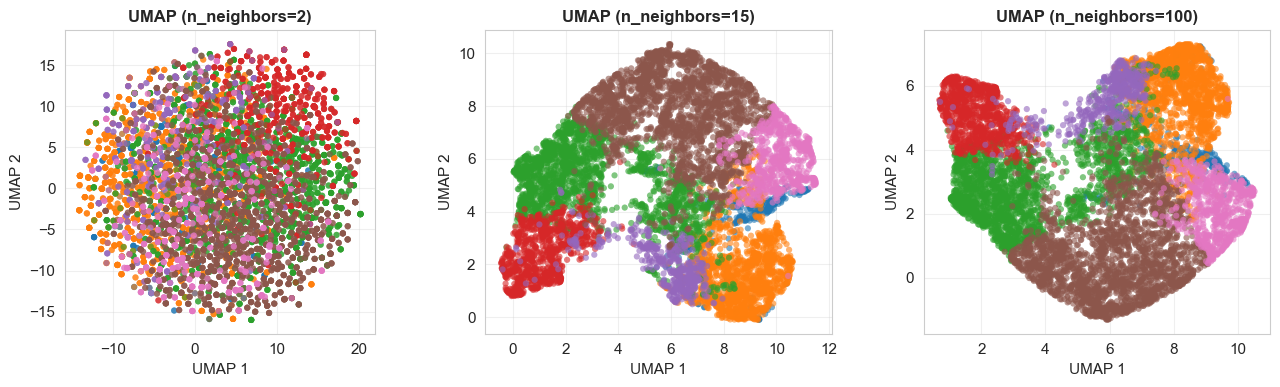

In [28]:
# Visualize n_neighbors comparison
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

titles = [
    'UMAP (n_neighbors=2)',
    'UMAP (n_neighbors=15)',
    'UMAP (n_neighbors=100)'
]

# Get number of unique clusters
n_clusters = df['labels'].nunique()

# Create color map
colors = cm.tab10(np.linspace(0, 1, 10))

for idx, n_neigh in enumerate(n_neighbors_values):
    ax = axes[idx]
    X_umap = umap_results[n_neigh]
    
    # Plot each cluster separately for legend
    for label in sorted(df['labels'].unique()):
        mask = df['labels'] == label
        ax.scatter(
            X_umap[mask, 0],
            X_umap[mask, 1],
            c=[colors[label]],
            alpha=0.6,
            s=20,
            edgecolors='none',
            label=f'Cluster {label}' if idx == 0 else ''  # Only label first subplot
        )
    
    ax.set_title(titles[idx], fontsize=12, weight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_aspect(1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(right=0.88)  # Make room for legend

plt.show()

#### What value of n_neighbors gives more scattered view of the clusters? 
#### Which values of n_neighbors preserve better the overall structure of the data?

### `min_dist`

Controls how tightly points are allowed to be packed together <br>
Default is 0.1

In [29]:
#UMAP with different min_dist
min_dist_values = [0.0, 0.1, 0.99]
umap_mindist_results = {}

print("Running UMAP with different min_dist values...\n")

for min_d in min_dist_values:
    print(f"Computing UMAP with min_dist={min_d}")
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=15,
        min_dist=min_d,
        random_state=42,
        n_jobs=1
    )
    X_umap = reducer.fit_transform(df[metric_features])
    umap_mindist_results[min_d] = X_umap


Running UMAP with different min_dist values...

Computing UMAP with min_dist=0.0
Computing UMAP with min_dist=0.1
Computing UMAP with min_dist=0.99


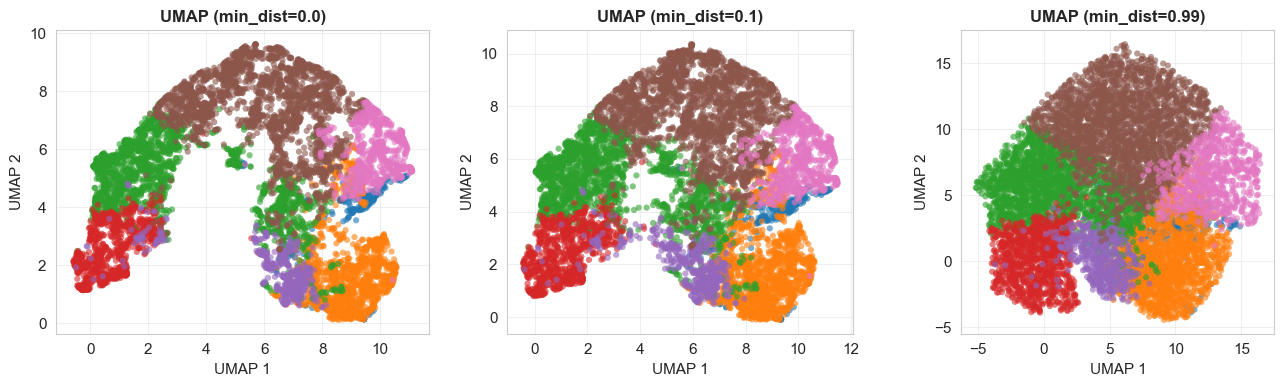

In [30]:
#Visualize min_dist comparison WITH LEGEND
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

titles = [
    'UMAP (min_dist=0.0)',
    'UMAP (min_dist=0.1)',
    'UMAP (min_dist=0.99)'
]

# Get number of unique clusters
n_clusters = df['labels'].nunique()

# Create color map
colors = cm.tab10(np.linspace(0, 1, 10))

# Plot UMAP visualizations
for idx, min_d in enumerate(min_dist_values):
    ax = axes[idx]
    X_umap = umap_mindist_results[min_d]
    
    # Plot each cluster separately for legend
    for label in sorted(df['labels'].unique()):
        mask = df['labels'] == label
        ax.scatter(
            X_umap[mask, 0],
            X_umap[mask, 1],
            c=[colors[label]],
            alpha=0.6,
            s=20,
            edgecolors='none',
            label=f'Cluster {label}' if idx == 0 else ''  # Only label first subplot
        )
    
    ax.set_title(titles[idx], fontsize=12, weight='bold')
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_aspect(1)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.subplots_adjust(right=0.88)  # Make room for legend

plt.show()

#### What value of min_dist gives more clumpier embeddings?
#### What value would be better for finer vs. broad topological structure?   

# Multi-method Comparison

Considerations: 
- Multiple methods provide validation confidence: consistent patterns strengthen recommendations
- Avoids over-interpreting single method results
- Visual patterns inform targeted marketing strategies

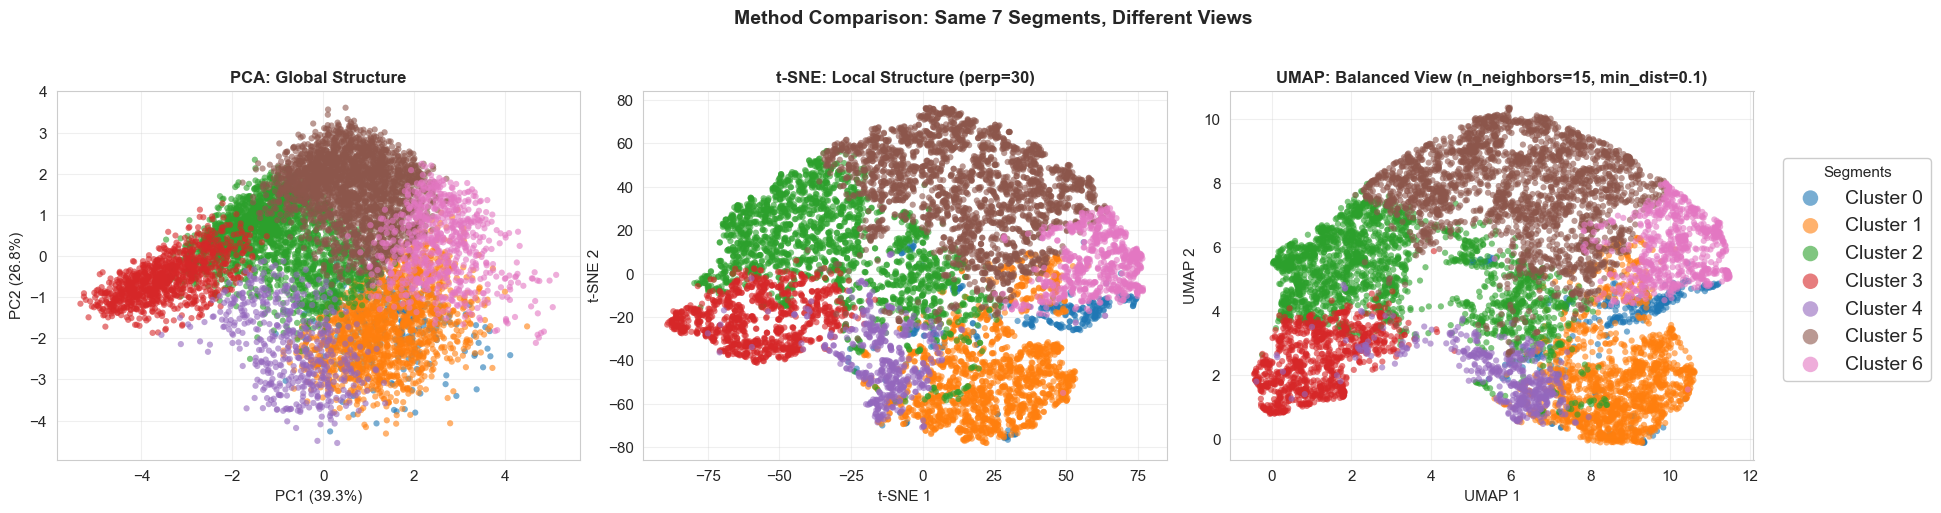

In [31]:
# Side-by-side method comparison
fig, axes = plt.subplots(1, 3, figsize=(20, 5))

# Get number of unique clusters
n_clusters = df['labels'].nunique()

# Create color map
colors = cm.tab10(np.linspace(0, 1, 10))

# PCA
for label in sorted(df['labels'].unique()):
    mask = df['labels'] == label
    axes[0].scatter(
        df.loc[mask, 'pca_1'], 
        df.loc[mask, 'pca_2'], 
        c=[colors[label]], 
        alpha=0.6, 
        s=20, 
        edgecolors='none',
        label=f'Cluster {label}'
    )
axes[0].set_title('PCA: Global Structure', fontsize=12, weight='bold')
axes[0].set_xlabel(f'PC1 ({var_explained[0]:.1%})')
axes[0].set_ylabel(f'PC2 ({var_explained[1]:.1%})')
axes[0].grid(True, alpha=0.3)

# t-SNE (perplexity=30)
X_tsne_30 = tsne_results[30]
for label in sorted(df['labels'].unique()):
    mask = df['labels'] == label
    axes[1].scatter(
        X_tsne_30[mask, 0], 
        X_tsne_30[mask, 1], 
        c=[colors[label]], 
        alpha=0.6, 
        s=20, 
        edgecolors='none'
    )
axes[1].set_title('t-SNE: Local Structure (perp=30)', fontsize=12, weight='bold')
axes[1].set_xlabel('t-SNE 1')
axes[1].set_ylabel('t-SNE 2')
axes[1].grid(True, alpha=0.3)

# UMAP (n_neighbors=15, min_dist=0.1)
X_umap_balanced = umap_results[15]
for label in sorted(df['labels'].unique()):
    mask = df['labels'] == label
    axes[2].scatter(
        X_umap_balanced[mask, 0], 
        X_umap_balanced[mask, 1], 
        c=[colors[label]], 
        alpha=0.6, 
        s=20, 
        edgecolors='none'
    )
axes[2].set_title('UMAP: Balanced View (n_neighbors=15, min_dist=0.1)', fontsize=12, weight='bold')
axes[2].set_xlabel('UMAP 1')
axes[2].set_ylabel('UMAP 2')
axes[2].grid(True, alpha=0.3)

# Add legend to the right of all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center left', bbox_to_anchor=(0.89, 0.5), 
           framealpha=1, title='Segments', fontsize=14, markerscale=2.5)

plt.suptitle('Method Comparison: Same 7 Segments, Different Views', 
             fontsize=14, weight='bold', y=1.02)
plt.tight_layout()
plt.subplots_adjust(right=0.88)  # Make room for legend
plt.show()

#### Where do the methods agree ? And disagree ?
#### Where can you find overlap between clusters ? sub-clusters ? any isolated cluster ? 
#### What area of the visualizations represent high value customers? And low value customers ?
#### What area of the visualizations represent preference for clothes ? And for other items ?
#### What clusters could be targeted for upselling strategies ? And for cross-selling ? 

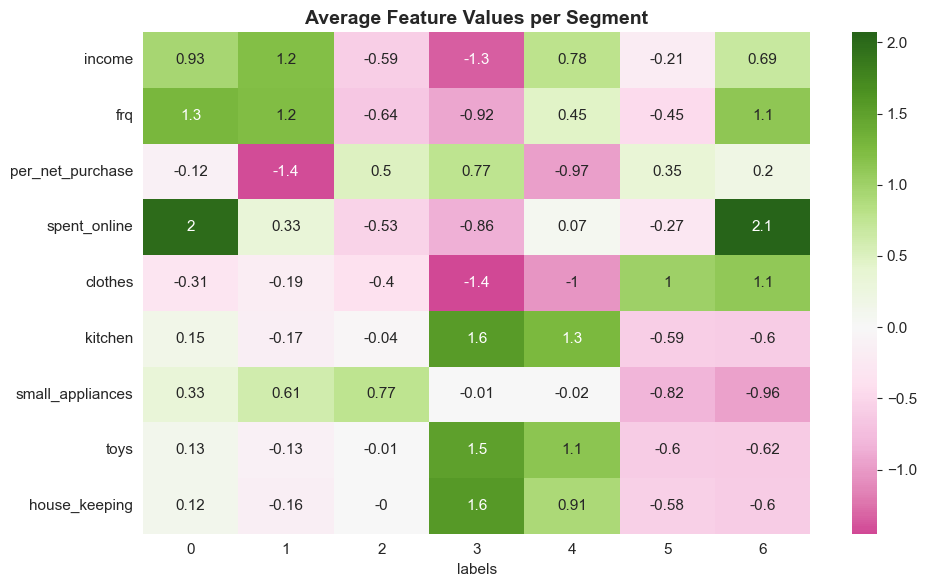

In [32]:
corr = df.groupby('labels')[metric_features].mean().round(2)
corr = corr.T

sns.heatmap(corr, annot=True, cmap='PiYG', center=0)
plt.title('Average Feature Values per Segment', fontsize=14, weight='bold')
plt.tight_layout()
plt.show()

In [33]:
df

age    income       frq       rcn   mnt   clothes   kitchen  \
0      78  0.743162  1.191605  0.457819  1402 -0.617023 -0.243065   
1      88  1.559488  1.100011 -1.535723  1537  0.166160 -0.790228   
2      34 -1.548542 -0.823463  0.557496    44 -0.834573  1.672006   
3      69  0.845528  0.550447 -1.402820   888  0.383710  0.440889   
4      69  0.782435  1.008417 -0.871209  1138  0.340200 -0.243065   
...   ...       ...       ...       ...   ...       ...       ...   
8812   70  0.618993  0.458853 -1.701851   837  0.209670  0.167308   
8813   64  0.874744  0.733635 -1.701851   896  0.731791 -0.243065   
8814   49 -0.455617 -0.731869 -1.535723    61  0.079139 -0.106274   
8815   38 -0.596155  0.825229  0.657173  1011 -0.442982  0.577680   
8816   86  2.034397  1.649574  0.756850  1668  0.427220 -0.653437   

      small_appliances      toys  house_keeping  ...  oh_dependents_1.0  \
0             1.216847  0.495837      -0.499274  ...                0.0   
1             0.740464 -0.374374      -0.631907  ...                0.0   
2            -0.371096 -0.809480       2.286023  ...                1.0   
3            -0.768082 -0.084304      -0.234007  ...                1.0   
4            -0.053508 -0.374374      -0.366640  ...                1.0   
...                ...       ...            ...  ...                ...   
8812         -0.132905  0.205767      -0.764540  ...                1.0   
8813         -0.609288 -0.519409      -0.366640  ...                1.0   
8814         -0.053508  0.060732      -0.101374  ...                1.0   
8815          0.581670 -0.809480       0.561792  ...                0.0   
8816         -0.291699 -0.229339      -0.101374  ...                1.0   

      oh_description_Kind of OK oh_description_Meh... oh_description_OK nice!  \
0                           0.0                   0.0                     0.0   
1                           0.0                   0.0                     0.0   
2                           1.0                   0.0                     0.0   
3                           0.0                   0.0                     1.0   
4                           0.0                   0.0                     0.0   
...                         ...                   ...                     ...   
8812                        1.0                   0.0                     0.0   
8813                        0.0                   0.0                     0.0   
8814                        0.0                   1.0                     0.0   
8815                        0.0                   0.0                     0.0   
8816                        0.0                   0.0                     0.0   

     oh_description_Take my money!! behavior_labels  product_labels  labels  \
0                               1.0               1               0       1   
1                               1.0               1               0       1   
2                               0.0               0               2       3   
3                               0.0               3               1       5   
4                               1.0               2               1       6   
...                             ...             ...             ...     ...   
8812                            0.0               2               0       0   
8813                            1.0               2               1       6   
8814                            0.0               0               0       2   
8815                            1.0               3               0       2   
8816                            1.0               2               1       6   

         pca_1     pca_2  
0     0.917984 -1.972051  
1     1.920114 -1.385964  
2    -2.794140  0.365292  
3     1.188147 -0.463503  
4     1.745094 -0.678004  
...        ...       ...  
8812  1.087856 -0.317156  
8813  1.928194  0.147432  
8814 -1.075030  1.346828  
8815  0.157169 -0.990559  
8816  3.265210 -1.411966  

[8792 rows x 37 columns]

In [34]:
# Define features to color by
color_features = ['income', 'frq', 'clothes', 'house_keeping']
feature_labels = ['Income', 'Purchase Frequency', 'Clothes Spend', 'Housekeeping Spend']

# Method titles
method_titles = ['PCA: Global Structure', 
                 't-SNE: Local Structure (perp=30)', 
                 'UMAP: Balanced View (n_neighbors=15)']
# Comparison - Multiple Features

fig, axes = plt.subplots(
    len(color_features), 
    len(method_titles), 
    figsize=(20, 16))



final_pca = df
final_tsne = tsne_results[30]
final_umap = umap_results[15]

# Get data for each method
methods_data = [
    (final_pca['pca_1'], final_pca['pca_2'], 'PCA'),
    (final_tsne[:, 0], final_tsne[:, 1], 't-SNE'),
    (final_umap[:, 0], final_umap[:, 1], 'UMAP')
]

# Plot each row
for row_idx, (feature, feature_label) in enumerate(zip(color_features, feature_labels)):
    feature_values = df[feature]
    vmin, vmax = feature_values.min(), feature_values.max()
    
    for col_idx, (x_data, y_data, method_name) in enumerate(methods_data):
        ax = axes[row_idx, col_idx]
        
        # Create scatter plot
        scatter = ax.scatter(
            x_data,
            y_data,
            c=feature_values,   # colors depend on feature values: yellow-high / purple-low
            cmap='viridis',
            alpha=0.5,
            s=20,
            edgecolors='none',
            vmin=vmin,
            vmax=vmax
        )
        
        # Set titles (only on top row)
        if row_idx == 0:
            ax.set_title(method_titles[col_idx], fontsize=12, weight='bold', pad=10)
        
        # Set axis labels
        if col_idx == 0:
            if method_name == 'PCA':
                ax.set_ylabel(f'{feature_label}\n\nPC2', fontsize=11)
            else:
                ax.set_ylabel(f'{feature_label}\n\n{method_name} 2', fontsize=11)
        else:
            ax.set_ylabel(f'{method_name} 2', fontsize=10)
        
        if row_idx == 2:  # Bottom row
            if method_name == 'PCA':
                ax.set_xlabel(f'PC1 ({var_explained[0]:.1%})', fontsize=10)
            else:
                ax.set_xlabel(f'{method_name} 1', fontsize=10)
        
        ax.grid(True, alpha=0.3)
        
        # Add colorbar on the right side of each row
        if col_idx == 2:
            cbar = fig.colorbar(scatter, ax=ax, pad=0.02, aspect=20, fraction=0.046)
            cbar.set_label(feature_label, fontsize=10, rotation=270, labelpad=15)

plt.suptitle('Method Comparison: Colored by Different Features', 
             fontsize=16, weight='bold', y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])
plt.show()


**Comprehensive Method Comparison:**

| Aspect | PCA | t-SNE | UMAP |
|--------|-----|--------|------|
| **Interpretability** | High (linear combos) | Low (abstract axes) | Medium (global context) |
| **Stability** | Perfect | Low | High |
| **Detail Level** | Global overview | Local micro-structure | Balanced |
| **Stakeholder Trust** | High (explainable) | Medium (requires explanation) | High (reproducible) |
| **New Data** | Easy projection | Requires recomputation | Can transform |
| **Computation Speed** | Fast | Slow | Fast |
| **Global Structure** | Excellent | Poor | Good |
| **Local Structure** | Poor | Excellent | Good |